---

# APTOS 2019 Blindness Detection
Link: https://www.kaggle.com/c/aptos2019-blindness-detection/overview

---

## A look at the data:
> Data description from the competition:

You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Your task is to create an automated analysis system capable of assigning a score based on this scale.

---

## Building the dataloader:

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [2]:
import gc
gc.collect()

22

In [3]:
pwd

'/home/harish/Desktop/my_fastai_notebooks/Vision'

In [4]:
path = Path('/home/harish/datasets/aptos2019_blindness_detection')
Path.BASE_PATH = path
path.ls()

(#5) [Path('train_images'),Path('train.csv'),Path('test_images'),Path('sample_submission.csv'),Path('test.csv')]

In [5]:
files = get_image_files(path)
files

(#5590) [Path('train_images/24f271c87e73.png'),Path('train_images/ee02294cc3d9.png'),Path('train_images/511fd66b2df8.png'),Path('train_images/a73d012c4c38.png'),Path('train_images/7da558d92100.png'),Path('train_images/b351ae99413a.png'),Path('train_images/e868c3da340b.png'),Path('train_images/76f3473df8a6.png'),Path('train_images/d5a39339ff3d.png'),Path('train_images/69591ebb198d.png')...]

In [6]:
PILImage.create(files[0]).shape

(1958, 2588)

In [7]:
train = pd.read_csv(path/'train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [8]:
len(train)

3662

In [9]:
train['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [10]:
test = pd.read_csv(path/'test.csv')
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [11]:
len(test)

1928

In [12]:
# presizing
item_tfms=Resize(480),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('id_code', pref=path/'train_images', suff='.png'),
    get_y=ColReader('diagnosis'), 
    splitter=RandomSplitter(seed=42),
    item_tfms = item_tfms,
    batch_tfms = batch_tfms
)

dls = dblock.dataloaders(train) 

/home/harish/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


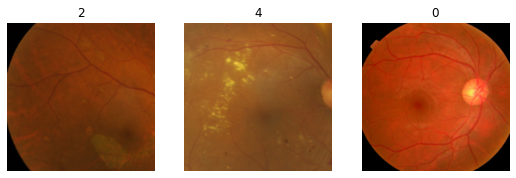

In [13]:
dls.show_batch(max_n=3)

---

## Model Training:

---

### Model evaluation metric

In [14]:
# The kaggle competition uses quadratic kappa as the metric for model evaluation
from sklearn.metrics import cohen_kappa_score

def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

---
##### What is Quadratic Weighted Kappa?
Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two ratings. This metric typically varies from 0 (random agreement between raters) to 1 (complete agreement between raters). In the event that there is less agreement between the raters than expected by chance, the metric may go below 0. The quadratic weighted kappa is calculated between the scores which are expected/known and the predicted scores. 

Results have 5 possible ratings, 0,1,2,3,4. The quadratic weighted kappa is calculated as follows. First, an N x N histogram matrix O is constructed, such that Oi,j corresponds to the number of adoption records that have a rating of i (actual) and received a predicted rating j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted rating scores.

An N-by-N histogram matrix of expected ratings, E, is calculated, assuming that there is no correlation between rating scores. This is calculated as the outer product between the actual rating's histogram vector of ratings and the predicted rating's histogram vector of ratings, normalized such that E and O have the same sum.

From these three matrices, the quadratic weighted kappa is calculated.

---

### Lr_find, 1 cycle policy, discriminative learning rates and mixed precision training

In [15]:
learn = cnn_learner(dls, resnet50, metrics=quadratic_kappa).to_fp16()

SuggestedLRs(valley=0.0014454397605732083)

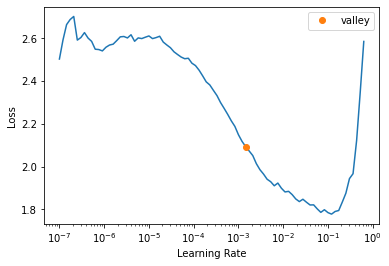

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(6, lr_max=1e-3)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,1.476709,0.913508,0.759797,00:33
1,1.150818,0.679586,0.802999,00:34
2,0.886174,0.587383,0.837844,00:34
3,0.738226,0.557119,0.843245,00:33
4,0.639420,0.509989,0.859478,00:34
5,0.586927,0.506236,0.863160,00:33


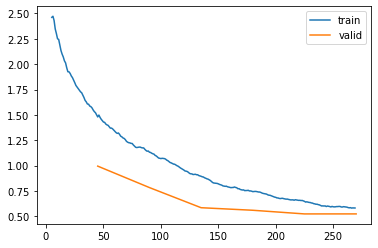

In [20]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=3.311311274956097e-06)

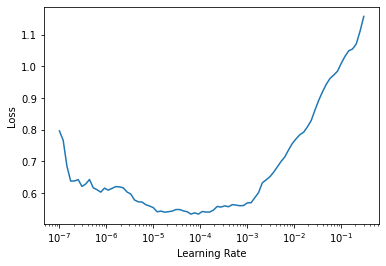

In [35]:
learn.unfreeze()
learn.lr_find()

In [36]:
# Discriminative learning rates
learn.fit_one_cycle(5, lr_max=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.555241,0.507405,0.878284,01:38
1,0.549248,0.566247,0.860750,01:38
2,0.513125,0.476110,0.878069,01:38
3,0.479043,0.464774,0.883675,01:40
4,0.462616,0.462504,0.885404,01:39


---
### Progressive Resizing, Mixup and Label Smoothing

In [65]:
def get_dls(bs, size, presize=480):    
    # presizing
    item_tfms=Resize(presize),
    batch_tfms=aug_transforms(size=size, min_scale=0.75)

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader('id_code', pref=path/'train_images', suff='.png'),
        get_y=ColReader('diagnosis'), 
        splitter=RandomSplitter(seed=42),
        item_tfms = item_tfms,
        batch_tfms = batch_tfms
    )
    return dblock.dataloaders(train, bs=bs) 

In [66]:
# getting a dataloader of bs=64 and size=128*128 and presize of 460
dls = get_dls(64, 128)

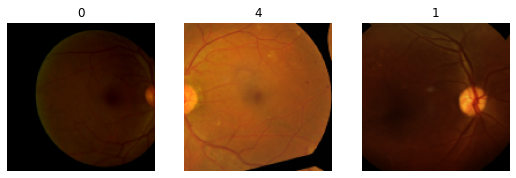

In [67]:
dls.show_batch(max_n=3)

In [77]:
# Adding mixup as a callback and using LabelSmoothingCrossEntropy as the loss function
Mixup = MixUp(0.5)

learn = cnn_learner(dls, resnet50, metrics=quadratic_kappa, cbs=Mixup, loss_func=LabelSmoothingCrossEntropy()).to_fp16()

In [78]:
learn.fit_one_cycle(12, lr_max=1e-3)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,2.240340,1.159314,0.679538,01:36
1,1.994589,1.254662,0.703339,01:39
2,1.766247,1.060866,0.704474,01:37
3,1.558769,0.963282,0.768688,01:36
4,1.397904,0.896155,0.786161,01:39
5,1.289461,0.886733,0.774121,01:36
6,1.211742,0.861603,0.783972,01:37
7,1.158176,0.834274,0.793761,01:40
8,1.126660,0.828759,0.790308,01:37
9,1.104929,0.845170,0.800000,01:37


In [79]:
learn.save('/home/jupyter/models/aptos-resnet50-all-128')

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=6.309573450380412e-07)

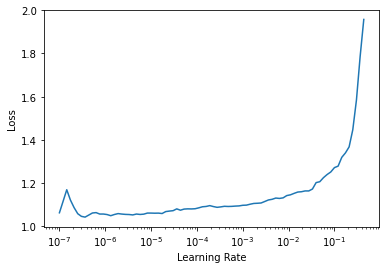

In [73]:
learn.unfreeze()
learn.lr_find()

In [80]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,1.085515,0.824826,0.798217,01:38
1,1.092255,0.836801,0.796933,01:37
2,1.091078,0.819014,0.807936,01:37
3,1.085214,0.825332,0.808721,01:37
4,1.087206,0.825002,0.807767,01:39
5,1.070440,0.803848,0.819398,01:36
6,1.056557,0.812275,0.803910,01:38
7,1.064875,0.817035,0.789356,01:37
8,1.063459,0.819222,0.802155,01:39
9,1.062459,0.810021,0.817902,01:37


In [81]:
learn.save('/home/jupyter/models/aptos-resnet50-all-128')

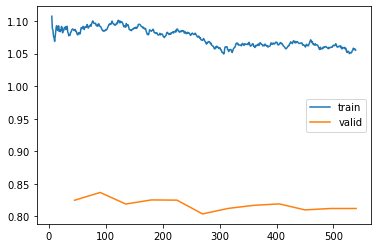

In [82]:
learn.recorder.plot_loss()

In [58]:
# Changing the models dataloader to one of bs=64 and size=256*256
learn.dls = get_dls(64, 256)
learn.freeze()

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=7.585775847473997e-07)

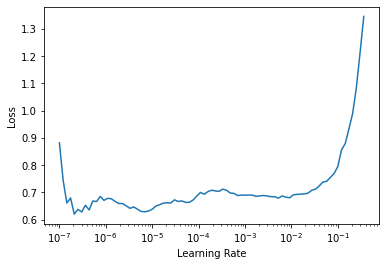

In [59]:
learn.lr_find()

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.692539,0.602424,0.834487,01:39
1,0.683284,0.595923,0.842699,01:41
2,0.672543,0.615739,0.833837,01:39


SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=9.12010818865383e-07)

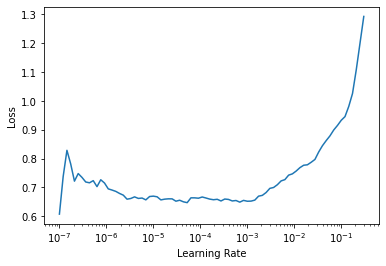

In [60]:
learn.fit_one_cycle(3, lr_max=1e-5)
learn.unfreeze()
learn.lr_find()

In [61]:
learn.fit_one_cycle(5, lr_max=slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.648793,0.529600,0.846812,01:41
1,0.608221,0.589548,0.839287,01:40
2,0.553944,0.486642,0.880283,01:41
3,0.514240,0.502344,0.862675,01:39
4,0.447140,0.478259,0.869647,01:41


In [ ]:
learn.save('/home/jupyter/models/aptos-resnet50-pr-256')